In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import sys
sys.path.append(".")
sys.path.append("..")
from kaplan_et_al.single_quantile_algo import kaplan_quantile

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Add Gaussian noise to spread out the values (to aid the quantile search)
def _plan_preprocess_data(data, alpha, universe, variance=0):
    if variance>0:
        noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=data.shape) #Scale is std
        data += noise
    noised_and_spread_data = np.concatenate(((data+alpha),(data),(data-alpha)))
    to_return = np.clip(noised_and_spread_data, universe[0], universe[1]) #Consistency: clip to universe
    return to_return

In [3]:
def clip_to_ellipsoid(inputs, C):
    x_norm = np.linalg.norm(inputs, axis=1)
    scale = C/x_norm
    scale[scale > 1.0] = 1.0 #Inplace adjust scale, i.e. min(C/x_norm,1.0)
    return np.apply_along_axis(lambda x: scale*x, 0, inputs) #Scale each dimension accordingly


## Generate data

In [4]:
mean_x = 10
mean_y = 5
true_means = [mean_x, mean_y]
dimensions = 2
n = 1000
alpha = 1
covariance_matrix = np.diag([4**2, 1])
seed = 42
rng = np.random.RandomState(seed)
raw_data = rng.multivariate_normal(true_means, covariance_matrix, size=n)


## Algorithm parameters

In [5]:
# Plot params
xlim = 15
ylim = xlim

In [6]:
global_rho = 0.01#0.001#1
recenter_and_std_budget_proportion = 0.25
recenter_budget_proportion = 0.25
top_k_budget_proportion = 0.1
fill = True
regularization = True
chisquared = True
pre_variance = 0.1
pre_alpha = 0.1
k_groups = 1
universe_padding = 5
universe = (-xlim, xlim)
MIN_VALUE = 1e-30
max_std_distance = 2

In [7]:
# Divide budget

rho1 = global_rho*recenter_and_std_budget_proportion
rho2 = global_rho*(1-recenter_and_std_budget_proportion)

In [8]:
data = _plan_preprocess_data(raw_data, pre_alpha, universe) if pre_alpha>0 else raw_data

In [9]:
# Parameters for standard deviation and center prediction
std_upper_bound = 0.5*(universe[1]-universe[0])**2

search_budget_allocation = rho1/(dimensions)
center_prop=recenter_budget_proportion
if pre_alpha>0:
    search_budget_allocation/=3 #We've increased sensitivty from 1 to 3 by adding two elements
std_prediction_budget = search_budget_allocation*(1-center_prop)

In [10]:
# Kaplan for center prediction
center_predictions = np.apply_along_axis(lambda x: kaplan_quantile(x, universe, 0.5, search_budget_allocation*center_prop, None), 0, data)

In [11]:
# Calculate variance and group

# Shuffle elements before we pair them to prevent attacks on accuracy
rng = np.random.default_rng()
rng.shuffle(data)
odd, even = data[::2], data[1::2]
pairwise = np.array([0.5* (x-y)**2 for (x, y) in zip(odd, even)])
# Group into list of tuples to sum
groups = list(zip(*[iter(pairwise)]*k_groups))
# Sum and divide by k
robust_std_estimates = np.array(list(map(lambda s: s/k_groups, map(sum, groups))))
if fill:
    for _ in range(2 * k_groups - 1):
        rng.shuffle(data)
        odd, even = data[::2], data[1::2]
        pairwise = np.array([0.5* (x-y)**2 for (x, y) in zip(odd, even)])
        # Group into list of tuples to sum
        groups = list(zip(*[iter(pairwise)]*k_groups))
        # Sum and divide by k
        robust_std_estimates = np.concatenate((robust_std_estimates,
            np.array(list(map(lambda s: s/k_groups, map(sum, groups))))))
    std_prediction_budget /= 2 * k_groups


In [12]:
# Kaplan for standard deviation
var_predictions = np.apply_along_axis(lambda x: kaplan_quantile(x, (0, std_upper_bound), 0.5, std_prediction_budget, None), 0, robust_std_estimates)

if chisquared:
    var_predictions = var_predictions/(((1-(2/(9*k_groups)))**3))

std_predictions = np.sqrt(var_predictions)

real_vars = np.var(data, axis=0)
robust_mean =  np.mean(robust_std_estimates, axis=0)
robust_median = np.median(robust_std_estimates, axis=0)
assert real_vars.shape == var_predictions.shape
assert real_vars.shape == robust_median.shape 


## Standard deviation prediction

In [13]:
std_predictions

array([3.46052088, 1.01716622])

## Recenter

In [14]:
# Re-center around (approximately) 0
shifted_data = raw_data - center_predictions

In [15]:
# Scale
std = np.clip(std_predictions, MIN_VALUE, None) # Defensive: make sure std isn't negative
Delta = max_std_distance * std
if regularization:
    Delta += np.linalg.norm(Delta) / dimensions
Delta_norm = np.sqrt(np.linalg.norm(Delta, ord=1)) # denominator
B = np.sqrt(Delta) / Delta_norm
scaled_data = shifted_data * B  / Delta # Multiply each row vector with individual scalar values
universe_scale = max(B  / Delta)


In [16]:
# Find top-k quantile
top_k_budget = top_k_budget_proportion*rho2
norms = np.linalg.norm(scaled_data, axis=1)
universe_upper = universe_scale*universe[1]
universe_lower = 0

# Calculate where to clip
k = ((np.sqrt(n)+(2*np.sqrt(dimensions/top_k_budget)))/n)

print('k=', k)
print('\n\nClipping at {k}\nn={n}, rho={rho}, d={d} \n\n'.format(k=(1-k), n=n, rho=top_k_budget, d=dimensions))
top_k_length = np.apply_along_axis(lambda x: kaplan_quantile(x, (universe_lower,universe_upper), (1-k), top_k_budget, None), 0, norms)
rho = rho2-top_k_budget

# Clip x to fit in ellipsoid, based on top-k quantile
clipped_data = clip_to_ellipsoid(scaled_data, top_k_length)


k= 0.13490233250054823


Clipping at 0.8650976674994517
n=1000, rho=0.00075, d=2 




In [17]:
# Calculate noisy mean
means = np.mean(clipped_data,axis=0)
noise = np.random.normal(loc=0, scale=np.sqrt(2*top_k_length**2/rho) * 1/n, size=dimensions) # Gaussian noise scaled to sum to 1
noisy_means = means + noise
unclipped_noisy_means = np.mean(shifted_data * B  / Delta,axis=0) + noise


In [18]:
# Scale back
mean_estimations = (noisy_means * Delta / B) + center_predictions
unclipped_mean_estimations = (unclipped_noisy_means * Delta / B) + center_predictions


## RESULTS!

In [19]:
mean_estimations

array([10.02334991,  5.05035922])

In [20]:
# Universe we actually use in the algorithm
universe_scaling_factor = 100
(-dimensions*(covariance_matrix.max()**0.25)*universe_scaling_factor/2, dimensions*(covariance_matrix.max()**0.25)*universe_scaling_factor/2)

(-200.0, 200.0)

In [21]:
folder_name = '../algorithm-explained/'
if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
fig_format = 'pdf'
        
step1_name = folder_name+'raw_data.'+fig_format
step2_name = folder_name+'recentered_data.'+fig_format
step2point5_name = folder_name+'scaled_data.'+fig_format
step2point5_inverted_name = folder_name+'inverted_scaled_data.'+fig_format
step3_name = folder_name+'clipped_data.'+fig_format
step4_name = folder_name+'estimated_mean.'+fig_format

In [22]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [23]:

sns.set_style('darkgrid')
previous_step_marker = 'o'#'$\circ$'
data_marker_size = 30
previous_step_marker_size = 10
poi_marker_size = 200
unscaled_size = 200
palette = sns.color_palette('colorblind')
step1_color = palette[7]
step2_color = palette[0]
step3_color = palette[5]
step4_color = palette[1]

prediction_color = palette[9]
result_color = palette[3]

#current_step_color = palette[0] 
#previous_step_color = palette[7]
poi_color = palette[8]

transparency = 0.5

In [24]:
raw_frame = pd.DataFrame(raw_data, columns=['x', 'y'])
shifted_frame = pd.DataFrame(shifted_data, columns=['x', 'y'])
scaled_frame = pd.DataFrame(scaled_data, columns=['x', 'y'])
clipped_frame = pd.DataFrame(clipped_data, columns=['x', 'y'])

true_frame = pd.DataFrame({'x':true_means[0], 'y':true_means[1]}, index=[0])
noisy_means_frame = pd.DataFrame({'x':noisy_means[0], 'y':noisy_means[1]}, index=[0])
mean_frame = pd.DataFrame({'x':mean_estimations[0], 'y':mean_estimations[1]}, index=[0])

# Figure 1: raw data

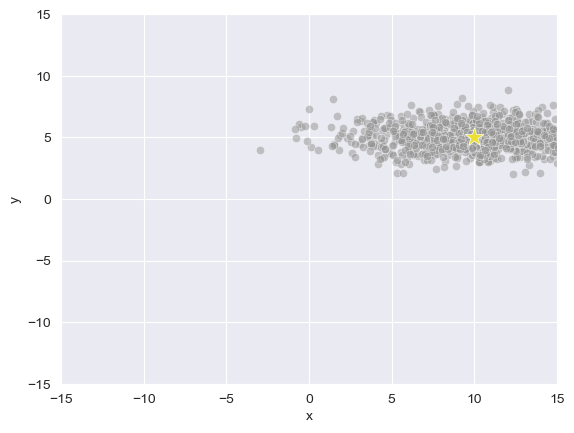

In [25]:
g = sns.scatterplot(x=raw_frame['x'], y=raw_frame['y'],
                    color=step1_color,
                    #color=current_step_color,
                    alpha=transparency,
                   )

g = sns.scatterplot(x=true_frame['x'], y=true_frame['y'], 
                    marker='*', 
                    s=poi_marker_size,
                    color=poi_color,
                    linewidth=0.5,
                   )

g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.figure.savefig(step1_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

# Figure 2: recenterd

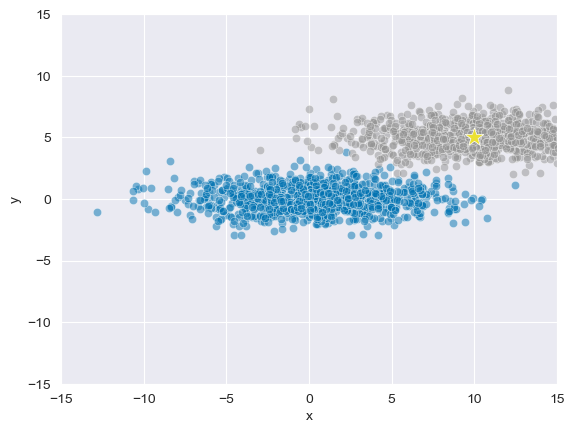

In [26]:
g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    color=step2_color,
                    #color=current_step_color
                    alpha=transparency,
                   )

g = sns.scatterplot(x=raw_frame['x'], y=raw_frame['y'],
                    #color=previous_step_color,
                    color=step1_color,
                    #s=previous_step_marker_size,
                    alpha=transparency)


g = sns.scatterplot(x=true_frame['x'], y=true_frame['y'], 
                    marker='*', 
                    s=poi_marker_size,
                    color=poi_color,
                    linewidth=0.5,
                   )

g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.figure.savefig(step2_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

## Figure 2.5: scaled

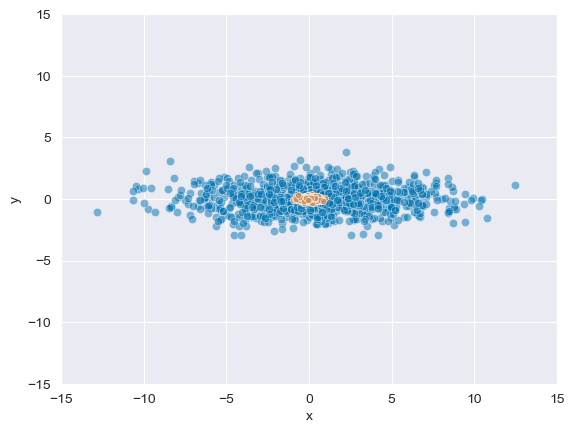

In [27]:
g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    #s=previous_step_marker_size,
                    #color=previous_step_color,
                    color=step2_color,
                    #s=unscaled_size,
                    alpha=transparency)

g = sns.scatterplot(x=scaled_frame['x'], y=scaled_frame['y'],                    
                    color=step3_color,
                    #color=current_step_color,
                    s=20,
                   )

g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)


g.figure.savefig(step2point5_inverted_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

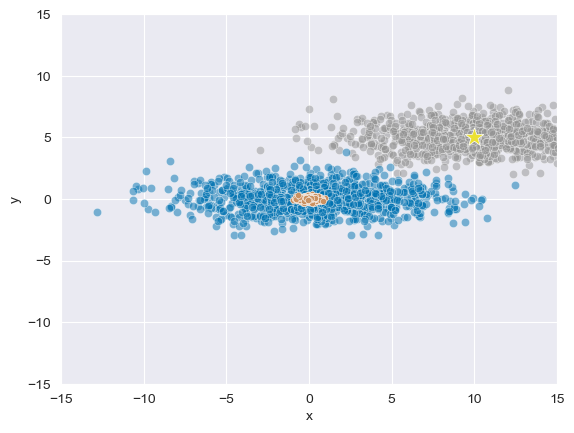

In [28]:
g = sns.scatterplot(x=raw_frame['x'], y=raw_frame['y'],
                    color=step1_color,
                    alpha=transparency)


g = sns.scatterplot(x=true_frame['x'], y=true_frame['y'], 
                    marker='*', 
                    s=poi_marker_size,
                    color=poi_color,
                    linewidth=0.5,
                   )

g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    color=step2_color,
                    alpha=transparency)

g = sns.scatterplot(x=scaled_frame['x'], y=scaled_frame['y'],                    
                    color=step3_color,
                    s=20,
                   )

g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.figure.savefig( folder_name+'fig3a.pdf', format=fig_format, bbox_inches='tight', pad_inches=0.5)

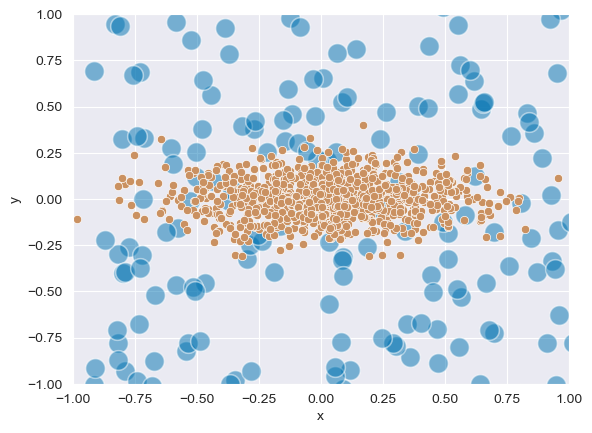

In [29]:

g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    color=step2_color,
                    s=unscaled_size,
                    alpha=transparency)

g = sns.scatterplot(x=scaled_frame['x'], y=scaled_frame['y'],                    
                    color=step3_color
                    )


g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.set_xlim(-1, 1)
g.set_ylim(-1, 1)

g.figure.savefig(step2point5_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

# Figure 3: scaled and clipped

In [30]:
center_predictions

array([9.83378726, 5.02602906])

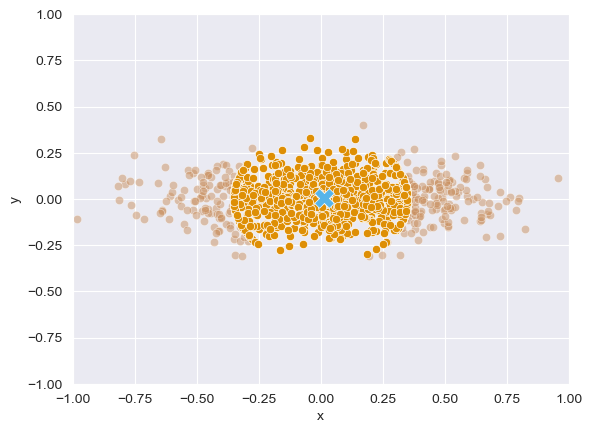

In [31]:

g = sns.scatterplot(x=scaled_frame['x'], y=scaled_frame['y'],
                    marker=previous_step_marker,
                    color=step3_color,
                    alpha=transparency)

g = sns.scatterplot(x=clipped_frame['x'], y=clipped_frame['y'],
                    color=step4_color,
                    )


g = sns.scatterplot(x=noisy_means_frame['x'], y=noisy_means_frame['y'], marker='X', s=poi_marker_size, linewidth=0.5, color=prediction_color)



g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.set_xlim(-1, 1)
g.set_ylim(-1, 1)

g.figure.savefig(step3_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

(-1.0, 1.0)

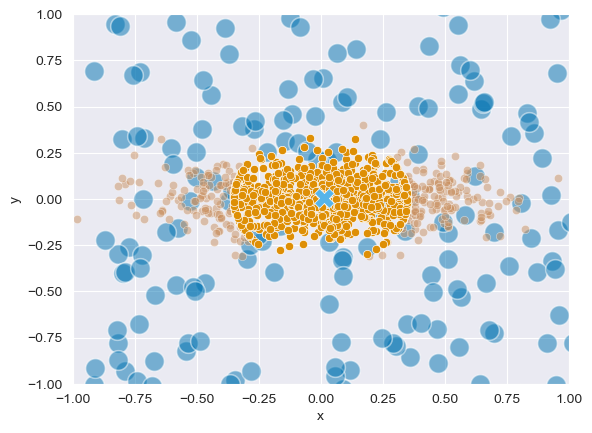

In [32]:
g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    color=step2_color,
                    s=unscaled_size,
                    alpha=transparency)

g = sns.scatterplot(x=scaled_frame['x'], y=scaled_frame['y'],
                    marker=previous_step_marker,
                    color=step3_color,
                    alpha=transparency)

g = sns.scatterplot(x=clipped_frame['x'], y=clipped_frame['y'],
                    color=step4_color,
                    )


g = sns.scatterplot(x=noisy_means_frame['x'], y=noisy_means_frame['y'], marker='X', s=poi_marker_size, linewidth=0.5, color=prediction_color)



g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.set_xlim(-1, 1)
g.set_ylim(-1, 1)

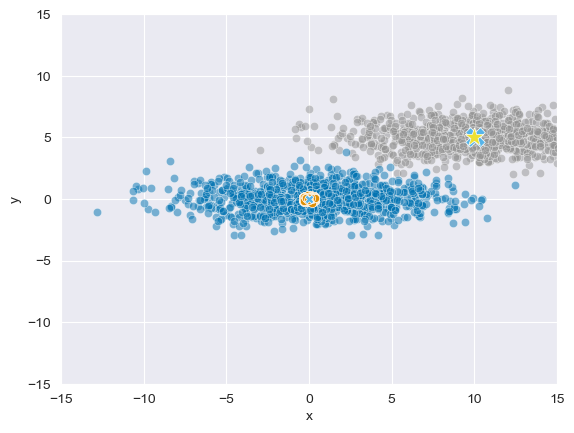

In [33]:
g = sns.scatterplot(x=raw_frame['x'], y=raw_frame['y'],
                    color=step1_color,
                    alpha=transparency
                   )

g = sns.scatterplot(x=mean_frame['x'], y=mean_frame['y'], marker='X', s=poi_marker_size, linewidth=0.5, color=prediction_color)
g = sns.scatterplot(x=true_frame['x'], y=true_frame['y'], marker='*', s=poi_marker_size, linewidth=0.5, color=poi_color)


g = sns.scatterplot(x=shifted_frame['x'], y=shifted_frame['y'],
                    color=step2_color,
                    alpha=transparency
                   )


g = sns.scatterplot(x=clipped_frame['x'], y=clipped_frame['y'],
                    color=step4_color,
                   )
g = sns.scatterplot(x=noisy_means_frame['x'], y=noisy_means_frame['y'], marker='X', s=poi_marker_size/5, linewidth=0.5, color=prediction_color)


g.set_xlim(-xlim, xlim)
g.set_ylim(-ylim, ylim)

g.figure.savefig(step4_name, format=fig_format, bbox_inches='tight', pad_inches=0.5)

In [34]:
true_means

[10, 5]

In [35]:
mean_estimations

array([10.02334991,  5.05035922])